# Taller Práctico Clase 4: SVM y el Poder de los Kernels

**Objetivo:** En este notebook, aplicaremos los conceptos de Máquinas de Vectores de Soporte (SVM) para resolver un problema de clasificación no lineal. Compararemos el rendimiento de SVM con diferentes kernels frente a un modelo lineal como la Regresión Logística y visualizaremos sus fronteras de decisión para desarrollar una intuición profunda sobre su funcionamiento.

**Temas a cubrir:**
1.  Generación y visualización de un dataset no lineal.
2.  Entrenamiento de un modelo de Regresión Logística como base.
3.  Entrenamiento de SVM con kernel lineal, polinómico y RBF.
4.  Visualización interactiva de las fronteras de decisión.
5.  Análisis del impacto de los hiperparámetros `C` y `gamma`.

## 1. Preparación del Entorno e Importación de Librerías

Primero, importaremos todas las librerías que necesitaremos para nuestro análisis.

In [50]:
# Manipulación de datos
import numpy as np

# Scikit-Learn para datasets, modelos y preprocesamiento
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Plotly para visualizaciones interactivas
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## 2. Generación y Exploración del Dataset

Para demostrar el poder de los kernels, necesitamos un dataset que no sea linealmente separable. `make_moons` de Scikit-Learn es perfecto para esto, ya que genera dos "medias lunas" entrelazadas.

In [51]:
# Generamos el dataset
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)

# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamos las características. Es una buena práctica para SVM.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualicemos los datos de entrenamiento
fig = px.scatter(x=X_train[:, 0], y=X_train[:, 1], color=y_train.astype(str),
                 color_discrete_map={'0': 'blue', '1': 'red'},
                 title='Dataset de Entrenamiento (Moons)',
                 labels={'x': 'Característica 1', 'y': 'Característica 2'})
fig.update_layout(showlegend=False, height=600, width=800)
fig.show()

## 3. Comparación de Modelos y Fronteras de Decisión

Ahora vamos a entrenar nuestros modelos y, para cada uno, visualizaremos la frontera de decisión que aprende. Para ello, crearemos una función auxiliar que nos facilite el ploteo.

In [52]:
def plot_decision_boundary(model, X, y, title):
    """Función para visualizar la frontera de decisión de un modelo de clasificación en 2D."""
    # Creamos una malla de puntos para evaluar el modelo
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predecimos sobre cada punto de la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Creamos la figura
    fig = go.Figure()

    # Añadimos la superficie de decisión (contour plot)
    fig.add_trace(go.Contour(
        x=xx[0], y=yy[:, 0],
        z=Z, showscale=False,
        colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'],
        line_width=0
    ))

    # Añadimos los puntos de datos
    fig.add_trace(go.Scatter(
        x=X[:, 0], y=X[:, 1], mode='markers',
        marker=dict(color=y, colorscale=['blue', 'red'], line=dict(width=1, color='DarkSlateGrey')),
        showlegend=False
    ))

    # Calculamos la precisión (accuracy)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)

    fig.update_layout(title=f'{title}<br>Accuracy: {acc:.4f}',
                      xaxis_title='Característica 1 (escalada)',
                      yaxis_title='Característica 2 (escalada)',
                      height=600, width=800,)
    return fig

### 3.1. Regresión Logística (Modelo Base)

In [4]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
fig = plot_decision_boundary(log_reg, X_train, y_train, 'Regresión Logística')
fig.show()

Como era de esperar, la Regresión Logística intenta separar los datos con una línea recta, fallando en capturar la estructura curva de las "lunas".

### 3.2. SVM con Kernel Lineal

In [5]:
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)
fig = plot_decision_boundary(svm_linear, X_train, y_train, 'SVM con Kernel Lineal')
fig.show()

El SVM lineal produce un resultado muy similar a la Regresión Logística. Ambos son modelos lineales y, por lo tanto, inadecuados para este problema.

### 3.3. SVM con Kernel Polinómico

In [6]:
svm_poly = SVC(kernel='poly', degree=3, random_state=42)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 3)')
fig.show()

¡Mucho mejor! El kernel polinómico puede crear una frontera curva que se adapta mucho mejor a la forma de los datos. La precisión mejora un poco.

### 3.4. SVM con Kernel RBF (Radial Basis Function)

In [7]:
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)
fig = plot_decision_boundary(svm_rbf, X_train, y_train, 'SVM con Kernel RBF')
fig.show()

El kernel RBF, que es el más flexible y popular, logra la mejor separación. Crea una frontera suave y compleja que se ajusta casi perfectamente a la estructura de los datos, logrando la mayor precisión.

## 4. El Impacto de los Hiperparámetros `C` y `gamma`

En SVM, `C` y `gamma` (para el kernel RBF) son cruciales. Vamos a visualizar su efecto.

- **`C` (Parámetro de regularización):** Controla el trade-off entre un margen ancho y clasificar correctamente todos los puntos. Un `C` bajo crea un margen más ancho pero permite más violaciones (más simple, más sesgo). Un `C` alto crea un margen más estrecho, intentando clasificar todo correctamente (más complejo, más varianza).
- **`gamma`:** Define la influencia de un único ejemplo de entrenamiento. Un `gamma` bajo significa que un punto tiene una influencia lejana (frontera más suave). Un `gamma` alto significa que un punto tiene una influencia muy local (frontera puede ser muy irregular).

In [8]:
# Creamos una figura con subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Bajo Gamma, Bajo C", "Alto Gamma, Bajo C",
    "Bajo Gamma, Alto C", "Alto Gamma, Alto C"
))

hyperparams = [(0.1, 1), (20, 1), (0.1, 2000), (20, 2000)]
plot_positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for (gamma, C), pos in zip(hyperparams, plot_positions):
    # Entrenar modelo
    svm = SVC(kernel='rbf', gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    
    # Crear malla
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Predecir en la malla
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Añadir trazas a la sub-figura
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'], line_width=0), row=pos[0], col=pos[1])
    fig.add_trace(go.Scatter(x=X_train[:, 0], y=X_train[:, 1], mode='markers', marker=dict(color=y_train, colorscale=['blue', 'red'])), row=pos[0], col=pos[1])

fig.update_layout(height=800, width=800, title_text="Efecto de Hiperparámetros C y Gamma en Kernel RBF", showlegend=False)
fig.show()

## 5. Desafíos

1.  **Evaluar en el conjunto de test:** Todos los `accuracy` se calcularon sobre los datos de entrenamiento para visualizar el ajuste. Calcula la precisión de los 4 modelos principales (LogReg, SVM Lineal, Polinómico, RBF con valores por defecto) en el conjunto de `X_test`, `y_test`. ¿Cuál generaliza mejor?
2.  **Probar otros datasets:** Importa el dataset de `make_circles` de `sklearn.datasets`. ¿Cómo se comportan los diferentes kernels en este caso? ¿Y con `make_blobs` con 3 centros?
3.  **Ajuste fino:** Usando los plots de la sección 4 como guía, intenta encontrar "a mano" una combinación de `C` y `gamma` que te parezca que da el mejor resultado (un buen balance entre ajuste y suavidad de la frontera).

## 6. Ejercicios Propuestos

1.  **Interpretación del Margen:** En el SVM con kernel lineal, ¿cómo podrías identificar visualmente cuáles son los vectores de soporte? (Pista: son los puntos más cercanos a la línea de separación).

2.  **Kernel Polinómico y Grado:** Modifica el grado `degree` del `SVC(kernel='poly', ...)` a 1, 2, 5 y 10. Describe cómo cambia la complejidad de la frontera de decisión y el riesgo de sobreajuste (overfitting).

3.  **El rol de `coef0`:** En el kernel polinómico, el parámetro `coef0` controla cuánto influyen los polinomios de grado alto vs. los de grado bajo. Investiga y experimenta con este parámetro. ¿Qué efecto tiene en la frontera de decisión?

4.  **SVM para Regresión (SVR):** La librería `sklearn.svm` también contiene `SVR`. Investiga cómo funciona SVR. A diferencia de SVM para clasificación que intenta poner una "calle" vacía entre clases, SVR intenta que la mayor cantidad de puntos queden *dentro* de la "calle". Aplica SVR a un dataset de regresión simple.

5.  **Coste Computacional:** Aumenta el número de muestras en `make_moons` a 5000 y luego a 20000. Mide el tiempo de entrenamiento de la Regresión Logística y del SVM con kernel RBF usando `%%timeit` en la celda. ¿Qué observas sobre la escalabilidad de SVM?

6.  **Importancia del Escalado:** Vuelve a ejecutar el notebook pero esta vez, comenta las líneas donde se usa `StandardScaler`. ¿Qué impacto tiene en el rendimiento del SVM, especialmente con kernel RBF? ¿Por qué crees que ocurre esto? (Pista: el kernel RBF depende de distancias).

7.  **Creando un Kernel Personalizado:** La clase `SVC` de Scikit-Learn permite pasar una función como kernel. Define una función en Python que reciba dos vectores `X1` y `X2` y devuelva su producto punto (kernel lineal). Úsala para entrenar un SVM: `SVC(kernel=mi_kernel_lineal)`. Obs: el parametro debe ser una "callable" que reciba dos arrays y devuelva un escalar. ¿Cómo se compara con el SVM lineal de Scikit-Learn?

8.  **El parámetro `C` a fondo:** Crea un bucle que entrene varios SVM con kernel lineal pero con valores de `C` muy diferentes (ej. 0.01, 1, 100, 10000). Para cada uno, imprime el número de vectores de soporte (`model.n_support_`). ¿Qué relación observas entre el valor de `C` y la cantidad de vectores de soporte?

9.  **Aplicación a un problema real:** Carga el dataset de cáncer de mama de sklearn (`load_breast_cancer`). Como es un dataset con muchas características, no podrás visualizar la frontera de decisión. En su lugar, usa `GridSearchCV` de `sklearn.model_selection` para encontrar la mejor combinación de `C` y `gamma` para un SVM con kernel RBF. Compara su `accuracy` en el conjunto de test con el de una Regresión Logística.

In [9]:
""" 
1)
Son los puntos que mas cerca estan de la recta de decision
"""

' \n1)\nSon los puntos que mas cerca estan de la recta de decision\n'

In [10]:
""" 
2)
"""
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Polinomio Grado 1", "Polinomio Grado 2",
    "Polinomio Grado 5", "Polinomio Grado 10"
))

polinomios_grado = [1,2,5,10]
plot_positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for grado, pos in zip(polinomios_grado, plot_positions):
    # Entrenar modelo
    svm_poly = SVC(kernel='poly', degree=grado, random_state=42)
    svm_poly.fit(X_train, y_train)
    
    # Crear malla
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Predecir en la malla
    Z = svm_poly.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Añadir trazas a la sub-figura
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'], line_width=0), row=pos[0], col=pos[1])
    fig.add_trace(go.Scatter(x=X_train[:, 0], y=X_train[:, 1], mode='markers', marker=dict(color=y_train, colorscale=['blue', 'red'])), row=pos[0], col=pos[1])

fig.update_layout(height=800, width=800, title_text="Efecto del grado del Polinomio", showlegend=False)
fig.show()

""" 
Se puede ver en los graficos debajo que a medida que el grado del polinomio aumenta; la frontera cambia acorde a la recta que mejor ajusta. 
Esto hace que a medida que aumentamos el grado del polinomio, empezamos a generar mas overfitting y la frontera de decision se vuelve mas compleja
"""

' \nSe puede ver en los graficos debajo que a medida que el grado del polinomio aumenta; la frontera cambia acorde a la recta que mejor ajusta. \nEsto hace que a medida que aumentamos el grado del polinomio, empezamos a generar mas overfitting y la frontera de decision se vuelve mas compleja\n'

In [ ]:
""" 
3)
El coef0, es el termino independiente en la funcion Kernel, lo que llamamos r en las diapositivas.
Como se observa, el agregado del parametro coef, ayuda a suavizar la frontera de decision, logrando un mejor ajuste para los polinomios de mayor grado
"""

fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Coef 0", "Coef 1",
    "Coef 10", "Coef 15"
))

coeficientes = [0, 1, 10, 15]
plot_positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for coef, pos in zip(coeficientes, plot_positions):
    # Entrenar modelo
    svm_poly = SVC(kernel='poly', degree=10, random_state=42, coef0=coef)
    svm_poly.fit(X_train, y_train)
    
    # Crear malla
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Predecir en la malla
    Z = svm_poly.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Añadir trazas a la sub-figura
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'], line_width=0), row=pos[0], col=pos[1])
    fig.add_trace(go.Scatter(x=X_train[:, 0], y=X_train[:, 1], mode='markers', marker=dict(color=y_train, colorscale=['blue', 'red'])), row=pos[0], col=pos[1])

fig.update_layout(height=800, width=800, title_text="Efecto del Coeficiente0", showlegend=False)
fig.show()

' \nComo se observa, el agregado del parametro coef, ayuda a suavizar la frontera de decision, logrando un mejor ajuste para los polinomios de mayor grado\n'

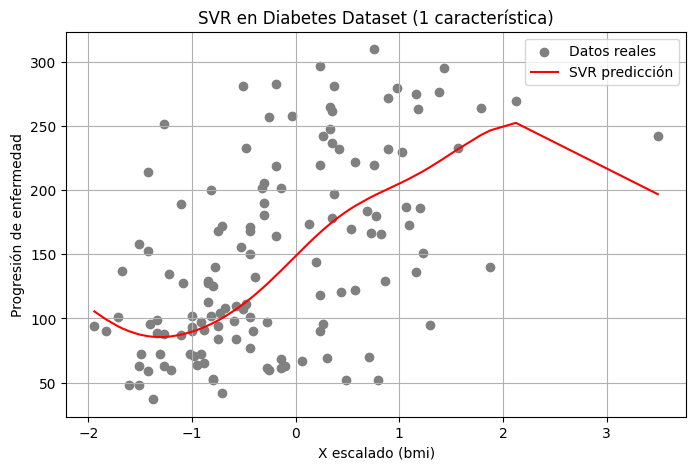

In [27]:
""" 
4)
"""
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.datasets import load_diabetes

# Cargamos el dataset
diabetes_X, diabetes_y = load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 2]
X_train, X_test, y_train, y_test = train_test_split(diabetes_X, diabetes_y, test_size=0.3, random_state=42)

# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos con SVR 
svr = SVR(kernel='rbf', epsilon=0.2, C=10)
svr.fit(X_train_scaled, y_train)
y_pred = svr.predict(X_test_scaled)


# Visualizacion
sorted_idx = np.argsort(X_test_scaled[:, 0])
X_sorted = X_test_scaled[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_test_sorted = y_test[sorted_idx]

plt.figure(figsize=(8, 5))
plt.scatter(X_test_scaled, y_test, color='gray', label='Datos reales')
plt.plot(X_sorted, y_pred_sorted, color='red', label='SVR predicción')
plt.title("SVR en Diabetes Dataset (1 característica)")
plt.xlabel("X escalado (bmi)")
plt.ylabel("Progresión de enfermedad")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
""" 
5)
"""
X, y = make_moons(n_samples=5000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
%%timeit
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

2.25 ms ± 86.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%%timeit
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

56.8 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
X, y = make_moons(n_samples=20000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
%%timeit
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

7.49 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%%timeit
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

877 ms ± 63.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
""" 
Se puede ver que a medida que las muestras aumentan, si bien el tiempo aumenta para ambos, en SVC con kernel RBF aumenta mucho mas. Lo cual no lo hace una buena opcion si buscamos
escalabilidad en grandes volumenes de datos
"""

In [ ]:
""" 
6)
El Kernel RBF al depender de las distancia entre las variables; si no escalamos hara que estas distancias sean mucho mas grandes y predominen aquellas que tengan los valores mas altos
Ademas, puede ser que el modelo no pueda encontrar una frontera correcta
"""
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

fig = plot_decision_boundary(svm_rbf, X_train, y_train, 'SVM con Kernel RBF')
fig.show()

In [49]:
""" 
7)
"""
def mi_kernel_lineal(x1, x2):
    return np.dot(x1, x2.T)

svm_custom = SVC(kernel=mi_kernel_lineal)
svm_custom.fit(X_train, y_train)

fig = plot_decision_boundary(svm_custom, X_train, y_train, 'Kernel Lineal a mano')
fig.show()

In [ ]:
""" 
8)
Se puede observar que a mayor C, permitimos menos violaciones en modelo. Tal es asi que si C-->0 permitiriamos muchas violacions, y cuando C-->inf nos vamos encontrar en un caso de
Hard Margin
"""
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "C 0.01", "C 1",
    "C 100", "C 10000"
))

cs = [0.01, 1, 100, 10000]
plot_positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for c, pos in zip(cs, plot_positions):
    # Entrenar modelo
    svm_linear = SVC(kernel='linear', random_state=42, C=c)
    svm_linear.fit(X_train, y_train)
    
    print(f"Vector de soporte para C={c}: {svm_linear.n_support_}")
    
    # Crear malla
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Predecir en la malla
    Z = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Añadir trazas a la sub-figura
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'], line_width=0), row=pos[0], col=pos[1])
    fig.add_trace(go.Scatter(x=X_train[:, 0], y=X_train[:, 1], mode='markers', marker=dict(color=y_train, colorscale=['blue', 'red'])), row=pos[0], col=pos[1])

fig.update_layout(height=800, width=800, title_text="Efecto de C", showlegend=False)
fig.show()

Vector de soporte para C=0.01: [103 103]
Vector de soporte para C=1: [59 58]
Vector de soporte para C=100: [58 57]
Vector de soporte para C=10000: [58 57]


In [ ]:
""" 
9)
"""
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV

# Cargamos el dataset
data, target = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

# Escalamos los datos
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


# Modelo Entrenado con Regresion Logistica
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(f"Accuracy de Regresion Logistica: {accuracy_score(y_test, y_pred):.4f}")


# Modelo entrenado con Kernel RBF
cs = 10 ** np.random.uniform(-2, 2, 15) # Genero 15 numeros aleatorios de C
gammas = 10 ** np.random.uniform(-4, 1, 15) # Genero 15 numeros aleatorios de gamma

svm = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid={'C': cs, 'gamma':gammas})
svm.fit(X_train, y_train)
y_pred = svm.best_estimator_.predict(X_test)

print(f"Los mejores parametros para SVM son: C={svm.best_params_['C']:.4f} y gamma={svm.best_params_['gamma']:.4f}")
print(f"Accuracy de SVM RBF: {accuracy_score(y_test, y_pred):.4f}")

Accuracy de Regresion Logistica: 0.9825
Los mejores parametros para SVM son: C=16.9422 y gamma=0.0010
Accuracy de SVM RBF: 0.9825
